# notebook with tasks for Capital One Data Science Challenge

### Executive Summary  - TO BE COMPLETED

Below are the code and answers to capital one's data science recruting challenge corresponding to the 4 areas of Load, Plot, Data Wrangling and Model

In [22]:
#import packages
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import datetime

#to display all columns in dataframe
from IPython.display import display
pd.options.display.max_columns = None

%matplotlib inline

import data

In [18]:
trnz = pd.read_json(path_or_buf = "C://Users/campb/DS/transactions/transactions.txt", lines = True)

# Question 1: Load

- a) Please describe the structure of the data. Number of records and fields in each record?
- b) Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

answers a couple cells down after output is examined

In [19]:
trnz.shape

(786363, 29)

In [20]:
trnz.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


In [21]:
trnz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [13]:
trnz.describe(include = 'all')

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363,786363.000000,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363.000000,786363.000000,786363.000000,786363,786363,786363.000000,786363,786363,786363,786363,786363,786363,786363,786363
unique,NaN,NaN,NaN,NaN,776637,NaN,2490,5,5,6,4,19,165,1820,2184,NaN,NaN,NaN,4,1,NaN,1,1,1,2,1,1,2,2
top,NaN,NaN,NaN,NaN,2016-12-25T14:04:15,NaN,Uber,US,US,05,01,online_retail,03/2029,2014-06-21,2016-03-15,NaN,NaN,NaN,PURCHASE,,NaN,,,,False,,,False,False
freq,NaN,NaN,NaN,NaN,4,NaN,25613,774709,778511,315035,628787,202156,5103,33623,3819,NaN,NaN,NaN,745193,786363,NaN,786363,786363,786363,433495,786363,786363,785320,773946
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,NaN,136.985791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,544.467338,544.183857,4757.417799,NaN,NaN,4508.739089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,NaN,147.725569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.524220,261.551254,2996.583810,NaN,NaN,6457.442068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,NaN,33.650000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.000000,310.000000,2178.000000,NaN,NaN,689.910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,NaN,87.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.000000,535.000000,4733.000000,NaN,NaN,2451.760000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,NaN,191.480000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,785.000000,785.000000,7338.000000,NaN,NaN,5291.095000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### - a) Please describe the structure of the data. Number of records and fields in each record?

- the number of records in total is 786,363 that span across 29 columns
- there are numeric, text and date columns throughout the dataset but the date columns have not been converted to dates
- there is a transactionDateTime column that is still stored as text after initial import that we'll need to convert to time, along with currentExpDate, accountOpenDate and dateOfLastAddressChange
- the info() function says that there are no nulls for all of the columns but the head() output shows blank values for the 1st 5 rows of echoBuffer, merchantState, merchantZip, merchantCity, posOnPremises, recurringAuthInd and the describe function shows that these columns are entirely blank because there's only 1 unique value and its a blank string so we can just drop these columns
- lets check to see if there are any string or numeric values that are actually blank

#### - b) Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate. -> Seen in cell immediately above

- the numeric values have reasonable upper and lower limits: availableMoney has a negative value which, assuming this is something analogous to creditLimit - currentBalance, is possible that someone spent more than their creditLimit 
- the non-date string values dont have many unique values other than merchantName, 2,490, and merchantCategoryCode, 19, which we'd need to consolidate if we want to do logistic regression to prevent separability

In [55]:
#drop columns with all blanks
trnz2 = trnz.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], axis = 1)

check if string variables are actually blanks

In [30]:
trnz2.apply(lambda x: (x == "").value_counts(), axis = 0)

C:\Users\campb\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
False,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,781801,785639,782309,785954,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,785665,786363.0,786363.0,786363.0,786363.0
True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4562,724,4054,409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,698,NaN,NaN,NaN,NaN


blanks in above string columns include
- 4,562 in acqCountry
- 724 in merchantCountryCode
- 4,054 in posEntryMode
- 409 in posConditionCode
- 698 in transactionType

In [31]:
trnz2.loc[ trnz2.acqCountry == ""].sample(30)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
394528,438823501,438823501,20000,4551.29,2016-05-18T15:19:48,17.73,amazon.com,,US,05,01,online_retail,01/2029,2014-03-06,2016-01-09,844,844,6815,PURCHASE,15448.71,False,False,False
299562,302906858,302906858,20000,13299.72,2016-06-29T15:00:43,169.48,oldnavy.com,,US,02,08,online_retail,12/2028,2014-10-28,2014-10-28,621,621,1911,REVERSAL,6700.28,False,False,False
199759,132629755,132629755,5000,1288.93,2016-05-26T04:52:03,108.16,gap.com,,US,09,01,online_retail,11/2027,2015-12-17,2016-03-04,337,337,8208,PURCHASE,3711.07,False,False,False
655441,570884863,570884863,5000,3861.38,2016-06-04T21:42:10,17.36,EZ Putt Putt #755869,,US,05,01,entertainment,08/2031,2012-10-09,2016-06-02,289,289,2194,PURCHASE,1138.62,True,False,False
473236,102204865,102204865,2500,2436.10,2016-02-07T05:08:10,419.91,Rodeway Inn #829626,,US,05,01,hotels,01/2029,2015-11-29,2015-11-29,408,408,2779,PURCHASE,63.90,True,False,False
389448,537892725,537892725,5000,429.27,2016-08-20T15:30:55,53.31,ebay.com,,US,05,01,online_retail,10/2024,2014-12-30,2014-12-30,929,929,4899,PURCHASE,4570.73,False,False,False
20061,265710406,265710406,15000,6868.21,2016-09-30T11:17:19,373.46,target.com,,US,09,01,online_retail,11/2020,2015-11-15,2016-05-11,289,289,516,PURCHASE,8131.79,False,False,True
345082,125128977,125128977,20000,5185.24,2016-03-21T22:36:51,167.77,apple.com,,US,02,01,online_retail,06/2020,2013-04-01,2013-04-01,817,817,7378,PURCHASE,14814.76,False,False,False
672433,782081187,782081187,15000,5669.15,2016-11-29T21:00:56,42.98,cheapfast.com,,US,05,08,online_retail,02/2026,2014-01-15,2016-11-08,363,363,7256,PURCHASE,9330.85,False,False,False
360019,183307154,183307154,5000,2332.74,2016-09-14T20:43:26,75.50,ebay.com,,US,02,01,online_retail,12/2022,2015-02-07,2015-02-07,958,958,3683,PURCHASE,2667.26,False,False,False


these are actually all blank for acqCountry so we'll replace these values of empty strings with "blank"

In [56]:
trnz2['acqCountry'] = np.where(trnz2.acqCountry == "", "blank", trnz2.acqCountry)
trnz2['merchantCountryCode'] = np.where(trnz2.merchantCountryCode == "", "blank", trnz2.merchantCountryCode)
trnz2['posEntryMode'] = np.where(trnz2.posEntryMode == "", "blank", trnz2.posEntryMode)
trnz2['posConditionCode'] = np.where(trnz2.posConditionCode == "", "blank", trnz2.posConditionCode)
trnz2['transactionType'] = np.where(trnz2.transactionType == "", "blank", trnz2.transactionType)

confirm whether blanks still exist

In [49]:
trnz2.apply(lambda x: (x == "").value_counts(), axis = 0)

C:\Users\campb\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
False,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363


no more blanks

nows lets try to see if there any numeric blanks

In [39]:
trnz2.apply(lambda x: (x == np.nan).value_counts(), axis = 0)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
False,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363


lets plot the numeric variables to see if there are any odd values that look like they could be placeholders for blanks

C:\Users\campb\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


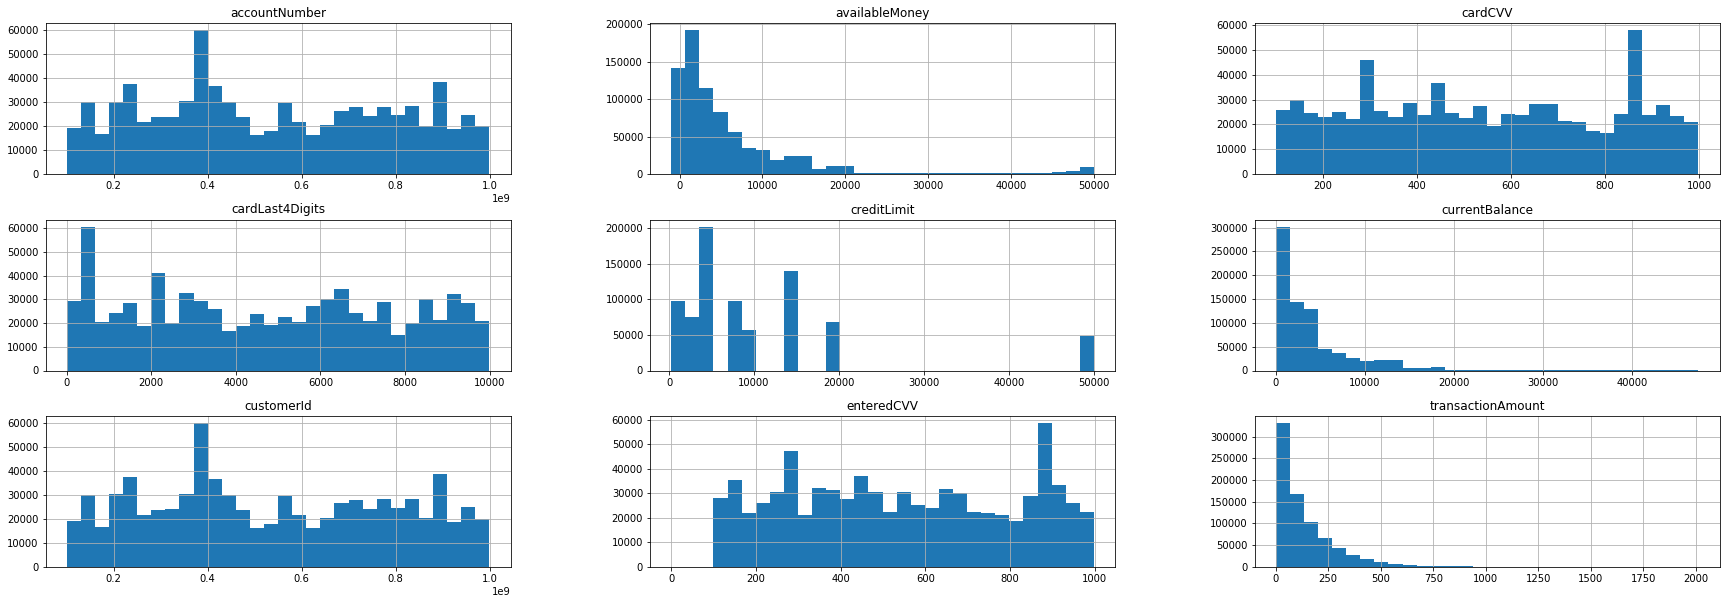

In [44]:
num_hist = plt.figure(figsize = (30, 10))
ax1 = num_hist.add_subplot(111)
trnz2.select_dtypes(include = ['int64', 'float64']).hist(ax = ax1, bins = 30);

- there are some numeric ranges that are markedly more popular like 4e8 in customerId and accountNumber but no values that are significantly farther away from the rest of the values like -9999 so we'll assume that none of the numeric values are blank

we'll convert the date columns to actual date values before moving forward
- transactionDateTime
- currentExpDate
- accountOpenDate
- dateOfLastAddressChange

In [57]:
trnz2[['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']].head()

,transactionDateTime,currentExpDate,accountOpenDate,dateOfLastAddressChange
0,2016-08-13T14:27:32,06/2023,2015-03-14,2015-03-14
1,2016-10-11T05:05:54,02/2024,2015-03-14,2015-03-14
2,2016-11-08T09:18:39,08/2025,2015-03-14,2015-03-14
3,2016-12-10T02:14:50,08/2025,2015-03-14,2015-03-14
4,2016-03-24T21:04:46,10/2029,2015-08-06,2015-08-06


In [58]:
trnz2['transactionDateTime_dt'] = pd.to_datetime(trnz2.transactionDateTime, format='%Y-%m-%dT%H:%M:%S')

In [59]:
trnz2['currentExpDate_dt'] = pd.to_datetime(trnz2.currentExpDate, format='%m/%Y')

In [60]:
trnz2['accountOpenDate_dt'] = pd.to_datetime(trnz2.accountOpenDate, format = '%Y-%m-%d')

In [61]:
trnz2['dateOfLastAddressChange_dt'] = pd.to_datetime(trnz2.dateOfLastAddressChange, format = '%Y-%m-%d')

confirm conversions are accurate

In [62]:
trnz2[['transactionDateTime', 'transactionDateTime_dt', 'currentExpDate', 'currentExpDate_dt', 'accountOpenDate', 'accountOpenDate_dt', 'dateOfLastAddressChange', 'dateOfLastAddressChange_dt']].head()

,transactionDateTime,transactionDateTime_dt,currentExpDate,currentExpDate_dt,accountOpenDate,accountOpenDate_dt,dateOfLastAddressChange,dateOfLastAddressChange_dt
0,2016-08-13T14:27:32,2016-08-13 14:27:32,06/2023,2023-06-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
1,2016-10-11T05:05:54,2016-10-11 05:05:54,02/2024,2024-02-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
2,2016-11-08T09:18:39,2016-11-08 09:18:39,08/2025,2025-08-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
3,2016-12-10T02:14:50,2016-12-10 02:14:50,08/2025,2025-08-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
4,2016-03-24T21:04:46,2016-03-24 21:04:46,10/2029,2029-10-01,2015-08-06,2015-08-06,2015-08-06,2015-08-06


yes, conversions look accurate, we'll proceed to question 2

# Question 2: Plot 

- Plot a histogram of the processed amounts of each transaction, the transactionAmount column.
- Report any structure you find and any hypotheses you have about that structure.

In [63]:
#get upper and lower limits of transactionAmount to inform binwidth
trnz2.transactionAmount.describe()

count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max        2011.540000
Name: transactionAmount, dtype: float64

In [67]:
2050/50

41.0

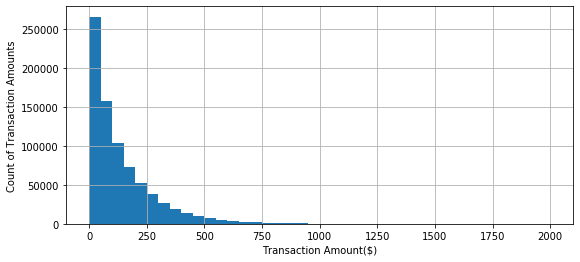

In [70]:
transplot = plt.figure(figsize = (20, 4))
ax1 = transplot.add_subplot(121)
trnz2.transactionAmount.hist(bins = range(0, 2050, 50), ax = ax1);
plt.xlabel('Transaction Amount($)');
plt.ylabel('Count of Transaction Amounts');

- the histogram of the transaction amount is largely right-skewed with a long right tail, largely following a log distribution
- most of the density is for transaction amounts less than 500, which leads me to hypothesize that most of these transactions are for everyday consumer products, entertainment, travel and billpay transactions as opposed to larger transactions like rent and loan payments
- it is odd that there are transactions with a value of 0 -> could that be something that isnt actually a purchase but still counts as a "transaction"?
- because of this distribution's shape, it should transform to a relatively normal distribution if we apply the log transformation, which could help in specifying variables in our model if we use a logistic regression model

In [72]:
trnz2['transactionAmount_log'] = trnz2.transactionAmount.apply(lambda x: np.log(x+0.01)) #have to shift by small constant bc 0 is undefined for the log distribution

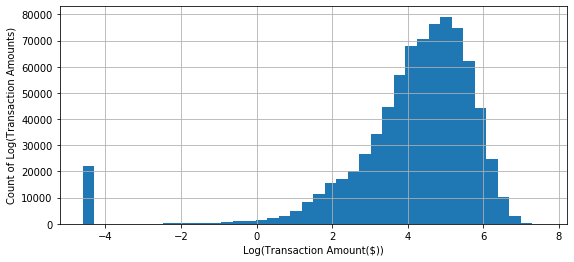

In [73]:
transplot2 = plt.figure(figsize = (20, 4))
ax1 = transplot2.add_subplot(121)
trnz2.transactionAmount_log.hist(bins = 40, ax = ax1);
plt.xlabel('Log(Transaction Amount($))');
plt.ylabel('Count of Log(Transaction Amounts)');

In [74]:
np.log(0.01)

-4.605170185988091

- the log transformed transaction amount is not quite normal and has a density below -4 corresponding to the shifted value of 0

# Question 3: Data Wrangling

- reversed transaction, where a purchase is followed by a reversal
- multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span

- Can you programmatically identify reversed and multi-swipe transactions?
- What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)
- Did you find anything interesting about either kind of transaction?

In [75]:
trnz2.head(2) #get column names to use in reversal and multiswipe transactions

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False,2016-08-13 14:27:32,2023-06-01,2015-03-14,2015-03-14,4.590665
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False,2016-10-11 05:05:54,2024-02-01,2015-03-14,2015-03-14,4.311068


In [76]:
#what is in transactionType?
trnz2.transactionType.unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', 'blank'],
      dtype=object)

reversal is already listed but multiswipe is not

In [101]:
# identify reversed and multiswipe transactions by sort dataset by account, customer, card, puchasetime
# if next transactionAmount is the same as the previous and from the same merchant that would mean a reversal 
# if the next transaction(s) have the same amount as the previous and is from the same merchant that would identify multi-swipe

trnz3 = trnz2.sort_values(by = ['accountNumber', 'customerId', 'cardLast4Digits', 'transactionDateTime_dt'], ascending = True).reset_index(drop = True)

In [102]:
#check range of transactionDateTime to pick value to impute nulls with
trnz3.transactionDateTime_dt.describe()

count                  786363
unique                 776637
top       2016-12-25 14:04:15
freq                        4
first     2016-01-01 00:01:02
last      2016-12-30 23:59:45
Name: transactionDateTime_dt, dtype: object

In [129]:
trnz3['accountNumber_shift'] = trnz3.accountNumber.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['customerId_shift'] = trnz3.customerId.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['cardLast4Digits_shift'] = trnz3.cardLast4Digits.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['transactionDateTime_dt_shift'] = trnz3.transactionDateTime_dt.shift(periods = 1, axis = 'rows', fill_value = pd.to_datetime('2000-01-01 00:00:00', format = '%Y-%m-%d %H:%M:%S'))
trnz3['transactionAmount_shift'] = trnz3.transactionAmount.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['transactionType_shift'] = trnz3.transactionType.shift(periods = 1, axis = 'rows', fill_value = 'blank')
trnz3['merchantName_shift'] = trnz3.merchantName.shift(periods = 1, axis = 'rows', fill_value = 'blank')

In [130]:
def find_duplicates(row):
    if (row['accountNumber'] == row['accountNumber_shift']) & (row['customerId'] == row['customerId_shift']) &\
        (row['cardLast4Digits'] == row['cardLast4Digits_shift']) &\
        (row['transactionDateTime_dt'] <= (row['transactionDateTime_dt_shift'] + datetime.timedelta(hours = 24))) &\
        (row['transactionType'] == 'REVERSAL') & (row['transactionType_shift'] == 'PURCHASE') &\
        (row['transactionAmount'] == row['transactionAmount_shift']) & (row['merchantName'] == row['merchantName_shift']):
        return 'reversed'
    elif (row['accountNumber'] == row['accountNumber_shift']) & (row['customerId'] == row['customerId_shift']) &\
        (row['cardLast4Digits'] == row['cardLast4Digits_shift']) &\
        (row['transactionDateTime_dt'] <= (row['transactionDateTime_dt_shift'] + datetime.timedelta(hours = 24))) &\
        (row['transactionType'] == 'PURCHASE') & (row['transactionType_shift'] == 'PURCHASE') &\
        (row['transactionAmount'] == row['transactionAmount_shift']) & (row['merchantName'] == row['merchantName_shift']):
        return 'multi_swipe'
    else:
        return 'non_duplicate'

In [131]:
trnz3['duplicateType'] = trnz3.apply(find_duplicates, axis = 1)

In [132]:
trnz3.duplicateType.value_counts(dropna = False)

non_duplicate    773519
multi_swipe        7342
reversed           5502
Name: duplicateType, dtype: int64

check some transactions

In [136]:
trnz3.loc[trnz3.duplicateType == 'reversed', ['cardLast4Digits', 'transactionAmount']].sample(5)

,cardLast4Digits,transactionAmount
632498,9395,9.68
33902,4609,62.52
758046,4165,232.20
550225,1377,54.12
267959,593,454.90


In [137]:
trnz3.loc[ (trnz3.cardLast4Digits == 9395) & (trnz3.transactionAmount == 9.68)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,duplicateType,transactionType_shift,merchantName_shift
632497,810471359,810471359,5000,1443.23,2016-01-15T13:46:32,9.68,apple.com,US,US,09,08,online_retail,11/2028,2015-11-03,2015-11-03,713,713,9395,PURCHASE,3556.77,False,False,False,2016-01-15 13:46:32,2028-11-01,2015-11-03,2015-11-03,2.271094,810471359,810471359,9395,2016-01-15 06:48:23,184.26,non_duplicate,REVERSAL,discount.com
632498,810471359,810471359,5000,1433.55,2016-01-15T13:48:44,9.68,apple.com,US,US,09,08,online_retail,11/2028,2015-11-03,2015-11-03,713,713,9395,REVERSAL,3566.45,False,False,False,2016-01-15 13:48:44,2028-11-01,2015-11-03,2015-11-03,2.271094,810471359,810471359,9395,2016-01-15 13:46:32,9.68,reversed,PURCHASE,apple.com


In [138]:
trnz3.loc[ (trnz3.cardLast4Digits == 4609) & (trnz3.transactionAmount == 62.52)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,duplicateType,transactionType_shift,merchantName_shift
33901,142263758,142263758,2500,1294.95,2016-10-17T01:15:42,62.52,Next Day eCards,US,US,05,01,online_gifts,07/2030,2013-09-19,2016-02-03,522,522,4609,PURCHASE,1205.05,False,False,False,2016-10-17 01:15:42,2030-07-01,2013-09-19,2016-02-03,4.135646,142263758,142263758,4609,2016-10-16 21:00:34,155.63,non_duplicate,PURCHASE,williamssonoma.com
33902,142263758,142263758,2500,1232.43,2016-10-17T01:17:07,62.52,Next Day eCards,US,US,05,01,online_gifts,07/2030,2013-09-19,2016-02-03,522,522,4609,REVERSAL,1267.57,False,False,False,2016-10-17 01:17:07,2030-07-01,2013-09-19,2016-02-03,4.135646,142263758,142263758,4609,2016-10-17 01:15:42,62.52,reversed,PURCHASE,Next Day eCards


In [139]:
trnz3.loc[ (trnz3.cardLast4Digits == 4165) & (trnz3.transactionAmount == 232.20)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,duplicateType,transactionType_shift,merchantName_shift
758045,957964653,957964653,15000,11791.95,2016-10-04T18:42:28,232.2,walmart.com,US,US,05,01,online_retail,12/2026,2015-10-12,2015-10-12,784,784,4165,PURCHASE,3208.05,False,False,False,2016-10-04 18:42:28,2026-12-01,2015-10-12,2015-10-12,5.447642,957964653,957964653,4165,2016-09-23 23:45:48,58.97,non_duplicate,PURCHASE,Sunoco Gas #316345
758046,957964653,957964653,15000,11559.75,2016-10-04T18:43:58,232.2,walmart.com,US,US,05,01,online_retail,12/2026,2015-10-12,2015-10-12,784,784,4165,REVERSAL,3440.25,False,False,False,2016-10-04 18:43:58,2026-12-01,2015-10-12,2015-10-12,5.447642,957964653,957964653,4165,2016-10-04 18:42:28,232.20,reversed,PURCHASE,walmart.com


reversed transactions look right so now lets check multi_swipe

In [140]:
trnz3.loc[trnz3.duplicateType == 'multi_swipe', ['cardLast4Digits', 'transactionAmount']].sample(5)

,cardLast4Digits,transactionAmount
208152,9685,113.57
714069,9102,151.64
98304,863,21.80
100763,258,335.93
374177,2934,59.01


In [141]:
trnz3.loc[ (trnz3.cardLast4Digits == 9685) & (trnz3.transactionAmount == 113.57)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,duplicateType,transactionType_shift,merchantName_shift
208151,346419123,346419123,7500,7500.00,2016-02-01T21:54:38,113.57,Starbucks #516830,US,US,02,01,fastfood,06/2026,2015-04-14,2015-04-14,149,149,9685,PURCHASE,0.00,True,False,False,2016-02-01 21:54:38,2026-06-01,2015-04-14,2015-04-14,4.732507,346419123,346419123,9685,2016-01-31 17:26:20,3.56,non_duplicate,REVERSAL,discount.com
208152,346419123,346419123,7500,7386.43,2016-02-01T21:57:16,113.57,Starbucks #516830,US,US,02,01,fastfood,06/2026,2015-04-14,2015-04-14,149,149,9685,PURCHASE,113.57,True,False,False,2016-02-01 21:57:16,2026-06-01,2015-04-14,2015-04-14,4.732507,346419123,346419123,9685,2016-02-01 21:54:38,113.57,multi_swipe,PURCHASE,Starbucks #516830
208153,346419123,346419123,7500,7272.86,2016-02-01T21:58:18,113.57,Starbucks #516830,US,US,02,01,fastfood,06/2026,2015-04-14,2015-04-14,149,149,9685,PURCHASE,227.14,True,False,False,2016-02-01 21:58:18,2026-06-01,2015-04-14,2015-04-14,4.732507,346419123,346419123,9685,2016-02-01 21:57:16,113.57,multi_swipe,PURCHASE,Starbucks #516830


In [142]:
trnz3.loc[ (trnz3.cardLast4Digits == 9102) & (trnz3.transactionAmount == 151.64)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,duplicateType,transactionType_shift,merchantName_shift
714068,894938833,894938833,15000,2371.86,2016-12-12T11:00:25,151.64,Walgreens #808671,US,US,09,01,health,06/2020,2014-11-05,2016-11-13,689,689,9102,PURCHASE,12628.14,True,False,False,2016-12-12 11:00:25,2020-06-01,2014-11-05,2016-11-13,5.021575,894938833,894938833,9102,2016-12-12 10:38:19,377.18,non_duplicate,PURCHASE,NYSC #331326
714069,894938833,894938833,15000,2220.22,2016-12-12T11:01:18,151.64,Walgreens #808671,US,US,09,01,health,06/2020,2014-11-05,2016-11-13,689,689,9102,PURCHASE,12779.78,True,False,False,2016-12-12 11:01:18,2020-06-01,2014-11-05,2016-11-13,5.021575,894938833,894938833,9102,2016-12-12 11:00:25,151.64,multi_swipe,PURCHASE,Walgreens #808671


### estimated total number of reversed and multi-swipe transactions

In [143]:
trnz3.duplicateType.value_counts(dropna = False)

non_duplicate    773519
multi_swipe        7342
reversed           5502
Name: duplicateType, dtype: int64

### estimated dollar amounts for reversed and multi_swipe transactions

In [146]:
trnz3.groupby('duplicateType')['transactionAmount'].sum().apply(lambda x: '${:,.2f}'.format(x))

duplicateType
multi_swipe        $1,087,165.85
non_duplicate    $105,808,565.16
reversed             $824,826.52
Name: transactionAmount, dtype: object

### over \\$820K in reversed transactions and \\$1.08M for multi swipe transactions

# CHECK FOR ANYTHING INTERESTING ABOUT MULTI-SWIPE AND REVERSED TRANSACTIONS
- particular merchants?
- particular days?
- particular geos?